# General informations

In [ ]:
## CHA-AIPH Project
# -*- coding: utf-8 -*-

"""
Created on Tue Jan 4 2021
@author: Tisseaux Antoine

This script is used to create a proper dataframe from the eICU demo database 
available on physionet.org

the final dataframe will be used to predict survival at hospital discharge for
all patients admited in ICU 
"""

'\nCreated on Tue Jan 4 2021\n@author: Tisseaux Antoine\n\nThis script is used to create a proper dataframe from the eICU demo database \navailable on physionet.org\n\nthe final dataframe will be used to predict survival at hospital discharge for\nall patients admited in ICU \n'

# set environement

Importing packages

In [ ]:
# Importing libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

Importing files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



loading csv files

In [ ]:
apacheApsVar = pd.read_csv('/content/drive/MyDrive/CHAIPH_PROJECT_GR2/data/initial_dataframes/apacheApsVar.csv', sep=",")
apachePredVar = pd.read_csv('/content/drive/MyDrive/CHAIPH_PROJECT_GR2/data/initial_dataframes/apachePredVar.csv', sep=",")
patient = pd.read_csv('/content/drive/MyDrive/CHAIPH_PROJECT_GR2/data/initial_dataframes/patient.csv', sep=",")

setting options for pandas

In [ ]:
# Displaying option: all columns
pd.set_option('display.max_columns', None)

# Data management 

## apacheApsVar:

In [ ]:
# replacing '-1' values in the dataframe because '-1' represent missing values 
# in apacheApsVar

apacheApsVar.replace(-1, np.nan, inplace=True)

# creating a new variable: 'glasgow' score from 'eyes', 
# 'motor' and 'verbal' assessement
glasgow = []
for i in range(len(apacheApsVar)):
    glasgow.append(apacheApsVar.iloc[i]['eyes'] + apacheApsVar.iloc[i]['motor'] 
                   + apacheApsVar.iloc[i]['verbal'])

apacheApsVar["glasgow"] = glasgow

# creating a subset for all interesting variables 
# of the apacheApsVar dataframe :
my_variables = ['patientunitstayid', 'intubated', 'vent', 'dialysis', 'wbc', 
                'temperature', 'respiratoryrate','heartrate', 'sodium', 
                'meanbp', 'ph', 'hematocrit', 'creatinine', 'albumin',
                'pao2', 'pco2','glucose', 'bilirubin', 'glasgow']

apacheApsVarSubset = apacheApsVar[my_variables]

## apachePredVar:

In [ ]:
# replacing '-1' values in the dataframe because '-1' represent missing values 
# in apachePredVar
apachePredVar.replace(-1, np.nan, inplace=True)

# creating a subset for all interesting variables of the apacheApsVar dataframe:

my_variables = ['patientunitstayid', 'gender', 'age', 'thrombolytics', 'aids', 
                'hepaticfailure', 'lymphoma', 'metastaticcancer', 'leukemia', 
                'immunosuppression', 'cirrhosis']

apachePredVarSubset = apachePredVar[my_variables]

## patient:

In [ ]:
# replacing empty strings '' values in the dataframe because '' represent 
# missing values in 'patient' dataframe
patient.replace("", np.nan, inplace=True)

# creating new variable for BMI from 'admissionheight' and 'admissionweight':
BMI = []
for i in range(len(patient)):
    if patient.iloc[i]['admissionweight'] != np.nan and patient.iloc[i]['admissionheight'] != np.nan:
        BMI.append(patient.iloc[i]['admissionweight']/((patient.iloc[i]['admissionheight']/100)**2))
patient['BMI'] = BMI

# creating binary outcome variable from 'hospitaldischargestatus' :
patient = pd.get_dummies(patient, prefix=['hospitaldischargestatus'], columns=['hospitaldischargestatus'])
patient['hospital_death'] = patient['hospitaldischargestatus_Expired']

# creating variable for patients with sepsis :
sepsis = []
for i in range(len(patient)):
    if "Sepsis" in str(patient.iloc[i]['apacheadmissiondx']):
      sepsis.append(1)
    else:
      sepsis.append(0)

patient['sepsis'] = sepsis

# creating a subset for all interesting variables of the apacheApsVar dataframe :
my_variables = ['patientunitstayid', 'patienthealthsystemstayid', 'uniquepid',
                'apacheadmissiondx', 'BMI', 'hospital_death', 'sepsis']

patientSubset = patient[my_variables]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


## Merging tables on patientunitstayid

In [ ]:
# merging tables on 'patientunitstayid' :
my_df_all_patients = pd.merge(apacheApsVarSubset, apachePredVarSubset)
my_df_all_patients = pd.merge(my_df_all_patients, patientSubset)

## Removing duplicates

removing duplicates on 'patienthealthsystemstayid" because we only want the initial prediction when the patient enter the ICU.

In [ ]:
# the duplicates with the smaller 'patientunitstayid' is removed
# the earliest unit admission is kept for analysis
# this is what we want because we need to make survival prediction from initial 
# ICU admission

my_df_all_patients.drop_duplicates(subset='patienthealthsystemstayid', inplace=True)

## Data visualization

Small visualization of the final dataset:

In [ ]:
print("\n\n10 first rows: \n")
my_df_all_patients.head(n=10)



10 first rows: 



,patientunitstayid,intubated,vent,dialysis,wbc,temperature,respiratoryrate,heartrate,sodium,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,glucose,bilirubin,glasgow,gender,age,thrombolytics,aids,hepaticfailure,lymphoma,metastaticcancer,leukemia,immunosuppression,cirrhosis,patienthealthsystemstayid,uniquepid,apacheadmissiondx,BMI,hospital_death,sepsis
0,141168,0,0,0,14.7,36.1,30.0,140.0,139.0,62.0,NaN,40.1,2.30,3.1,NaN,NaN,95.0,4.1,15.0,1.0,70.0,0,0,0,0,0,0,0,0,128919,002-34851,"Rhythm disturbance (atrial, supraventricular)",36.295906,1,0
1,141178,0,0,0,NaN,36.4,16.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,52.0,0,0,0,0,0,0,0,0,128927,002-33870,NaN,20.575852,0,0
2,141194,0,0,0,14.1,39.3,36.0,118.0,134.0,40.0,NaN,27.4,2.51,2.3,NaN,NaN,168.0,0.4,13.0,0.0,68.0,0,0,0,0,0,0,0,0,128941,002-5276,"Sepsis, renal/UTI (including bladder)",22.732803,0,1
3,141197,0,0,0,NaN,NaN,25.0,104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,0.0,71.0,0,0,0,0,0,0,0,0,128943,002-37665,"Sepsis, pulmonary",38.617545,0,1
4,141203,0,1,0,12.7,35.1,33.0,120.0,145.0,46.0,7.45,36.9,0.56,NaN,51.0,37.0,145.0,NaN,5.0,1.0,77.0,0,0,0,0,0,0,0,0,128948,002-23234,"Arrest, respiratory (without cardiac arrest)",27.421875,0,0
5,141208,0,0,0,NaN,36.7,37.0,102.0,NaN,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,1.0,25.0,0,0,0,0,0,0,0,0,128952,002-34521,"Overdose, sedatives, hypnotics, antipsychotics...",31.952749,0,0
6,141227,0,1,0,42.7,40.1,54.0,204.0,133.0,198.0,7.46,26.2,1.90,NaN,65.0,23.0,145.0,NaN,13.0,0.0,82.0,0,0,0,0,0,0,0,0,128968,002-21459,"Sepsis, pulmonary",23.914007,0,1
7,141229,0,1,0,NaN,36.4,32.0,57.0,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,1.0,NaN,0,0,0,0,0,0,0,0,128970,002-54296,"CHF, congestive heart failure",35.078125,0,0
8,141233,1,1,0,8.0,34.8,4.0,114.0,NaN,60.0,7.39,25.9,NaN,NaN,142.0,30.0,185.0,NaN,15.0,1.0,81.0,0,0,0,0,0,0,0,0,128973,002-8979,Mitral valve replacement,22.635548,0,0
9,141244,0,0,0,4.1,37.2,10.0,114.0,142.0,62.0,NaN,31.0,0.65,NaN,NaN,NaN,121.0,NaN,15.0,0.0,59.0,0,0,0,0,0,0,0,0,128982,002-23372,"Graft, femoral-popliteal bypass",28.392932,0,0


In [ ]:
print("table dimensions: \n", my_df_all_patients.shape)
print("\nnumber of patients: ", my_df_all_patients.shape[0])
print("\nnumber of variables: ", my_df_all_patients.shape[1])

table dimensions: 
 (160490, 35)

number of patients:  160490

number of variables:  35


In [ ]:
print("outcome count:\n")
my_df_all_patients['hospital_death'].value_counts()

outcome count:



0    146065
1     14425
Name: hospital_death, dtype: int64

In [ ]:
print("\n\ndata types: \n")
print(my_df_all_patients.info())



data types: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160490 entries, 0 to 171176
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   patientunitstayid          160490 non-null  int64  
 1   intubated                  160490 non-null  int64  
 2   vent                       160490 non-null  int64  
 3   dialysis                   160490 non-null  int64  
 4   wbc                        119786 non-null  float64
 5   temperature                149342 non-null  float64
 6   respiratoryrate            157628 non-null  float64
 7   heartrate                  158365 non-null  float64
 8   sodium                     126605 non-null  float64
 9   meanbp                     157988 non-null  float64
 10  ph                         36169 non-null   float64
 11  hematocrit                 123059 non-null  float64
 12  creatinine                 126045 non-null  float64
 13  albumin      

## Converting data types

In [ ]:
# conversion into categories:
binary_variables = ['vent', 'dialysis', 'intubated', 'gender', 'thrombolytics', 
                    'aids', 'hepaticfailure', 'lymphoma','metastaticcancer', 
                    'leukemia',  'immunosuppression', 'cirrhosis', 
                    'hospital_death', 'sepsis']

my_df_all_patients[binary_variables] = my_df_all_patients[binary_variables].astype('category')

# datatype:
print("\n\nverifying data types: \n")
print(my_df_all_patients.info())





verifying data types: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160490 entries, 0 to 171176
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   patientunitstayid          160490 non-null  int64   
 1   intubated                  160490 non-null  category
 2   vent                       160490 non-null  category
 3   dialysis                   160490 non-null  category
 4   wbc                        119786 non-null  float64 
 5   temperature                149342 non-null  float64 
 6   respiratoryrate            157628 non-null  float64 
 7   heartrate                  158365 non-null  float64 
 8   sodium                     126605 non-null  float64 
 9   meanbp                     157988 non-null  float64 
 10  ph                         36169 non-null   float64 
 11  hematocrit                 123059 non-null  float64 
 12  creatinine                 126045 non-null  fl

## Aberrant values:

In [ ]:
print("descriptive statistics \n")
my_df_all_patients.describe()

descriptive statistics 



,patientunitstayid,wbc,temperature,respiratoryrate,heartrate,sodium,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,glucose,bilirubin,glasgow,age,patienthealthsystemstayid,BMI
count,1.604900e+05,119786.000000,149342.00000,157628.000000,158365.000000,126605.000000,157988.000000,36169.000000,123059.000000,126045.000000,62801.000000,36169.000000,36169.000000,139083.000000,57022.000000,155801.000000,154668.000000,1.604900e+05,1.536170e+05
mean,1.752705e+06,12.225443,36.42682,25.231248,100.063379,137.965263,86.818595,7.353121,32.723066,1.545262,2.877927,130.507794,42.821348,163.602111,1.193878,13.013768,61.821178,1.394732e+06,inf
std,9.969118e+05,8.085599,0.93045,15.005593,30.989128,5.566824,41.678051,0.102181,6.897434,1.728813,0.692667,85.328980,13.388444,102.240055,2.351357,3.416545,16.857027,8.142933e+05,NaN
min,1.411680e+05,0.010000,20.00000,4.000000,20.000000,91.000000,40.000000,6.531000,6.000000,0.100000,1.000000,9.000000,6.500000,1.000000,0.100000,3.000000,0.000000,1.289190e+05,0.000000e+00
25%,9.611645e+05,7.400000,36.20000,11.000000,87.000000,135.000000,53.000000,7.302000,27.800000,0.710000,2.400000,76.000000,34.700000,97.000000,0.400000,13.000000,52.000000,7.075005e+05,2.347656e+01
50%,1.677328e+06,10.300000,36.50000,27.000000,104.000000,138.000000,66.000000,7.360000,32.800000,0.990000,2.900000,102.000000,40.600000,135.000000,0.670000,15.000000,64.000000,1.307442e+06,2.749748e+01
75%,2.743902e+06,15.200000,36.70000,36.000000,120.000000,141.000000,123.000000,7.420000,37.500000,1.600000,3.400000,153.000000,48.000000,199.000000,1.100000,15.000000,75.000000,2.208498e+06,3.286380e+01
max,3.353263e+06,198.100000,42.30000,60.000000,220.000000,195.000000,200.000000,7.810000,72.700000,24.950000,7.400000,636.000000,147.300000,2357.000000,60.200000,15.000000,89.000000,2.743110e+06,inf


### aberrant values for 'age':

In [ ]:
# Removing aberrant value for age:
my_df_all_patients.drop(my_df_all_patients.index[my_df_all_patients['age'] == 0], inplace=True)

age distribution with removed values

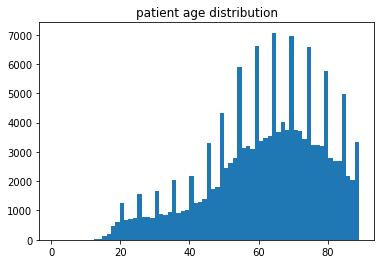

In [ ]:
plt.hist(my_df_all_patients['age'], bins=70)
plt.title("patient age distribution")
plt.show()

### aberrant values for BMI:

In [ ]:
my_df_all_patients.drop(my_df_all_patients.index[my_df_all_patients['BMI'] < 10], inplace=True)
my_df_all_patients.drop(my_df_all_patients.index[my_df_all_patients['BMI'] > 70], inplace=True)

BMI distribution with removed values:

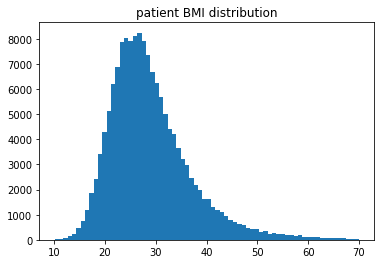

In [ ]:
plt.hist(my_df_all_patients['BMI'], bins=70)
plt.title("patient BMI distribution")
plt.show()

## Creating a subset with only sespis patients: 

In [ ]:
my_df_sepsis_patients = my_df_all_patients[my_df_all_patients['sepsis'] == 1]
my_df_sepsis_patients = my_df_sepsis_patients.dropna(subset=['apacheadmissiondx'])

## Dropping variables which are not used for predection

In [ ]:
my_df_all_patients.drop(['patientunitstayid', 'patienthealthsystemstayid', 'uniquepid',
                         'apacheadmissiondx'], axis=1, inplace=True)

my_df_sepsis_patients.drop(['patientunitstayid', 'patienthealthsystemstayid', 'uniquepid',
                         'apacheadmissiondx', 'sepsis'], axis=1, inplace=True)

## exporting non scaled dataframes

export all patients table

In [ ]:
# Write the DataFrame to CSV file.
with open('/content/drive/MyDrive/CHAIPH_PROJECT_GR2/data/final_dataframes/all_patients/my_df_all_patients_raw_data.csv', 'w') as f:
  my_df_all_patients.to_csv(f)

export the sepsis patients table

In [ ]:
my_df_sepsis_patients.to_csv(r'/content/drive/MyDrive/CHAIPH_PROJECT_GR2/data/final_dataframes/sepsis_patients/my_df_sepsis_patients_raw_data.csv', header=True)

## Missing values:

### missing values visualization

In [ ]:
# displaying percentage of missing values for each variable:
relative_missing_values = my_df_all_patients.isnull().sum()/len(my_df_all_patients)

print("missing values in percent:\n")
print(relative_missing_values)

missing values in percent:

intubated            0.000000
vent                 0.000000
dialysis             0.000000
wbc                  0.253418
temperature          0.069144
respiratoryrate      0.017537
heartrate            0.012971
sodium               0.210868
meanbp               0.015291
ph                   0.774812
hematocrit           0.232996
creatinine           0.214374
albumin              0.608664
pao2                 0.774812
pco2                 0.774812
glucose              0.133144
bilirubin            0.644723
glasgow              0.028839
gender               0.000495
age                  0.036359
thrombolytics        0.000000
aids                 0.000000
hepaticfailure       0.000000
lymphoma             0.000000
metastaticcancer     0.000000
leukemia             0.000000
immunosuppression    0.000000
cirrhosis            0.000000
BMI                  0.042776
hospital_death       0.000000
sepsis               0.000000
dtype: float64


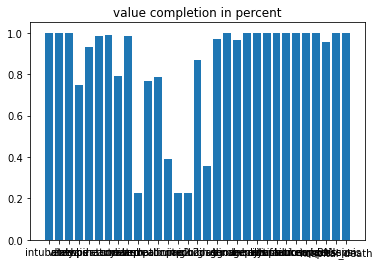

In [ ]:
# plot non-missing values percentage:
relative_recorded_values = 1 - relative_missing_values
plt.bar(relative_recorded_values.index, relative_recorded_values)
plt.title("value completion in percent")
plt.show()

### Dropping rows and columns:

In [ ]:
# dropping NaN values for some variables with small missing values:
my_df_all_patients.dropna(subset=['age', 'glasgow'], inplace=True)
my_df_sepsis_patients.dropna(subset=['age', 'glasgow'], inplace=True)

In [ ]:
# dropping all columns with more than 50% of missing values:
variablesToDrop = ['albumin', 'bilirubin', 'pao2', 'pco2', 'ph']
my_df_all_patients.drop(variablesToDrop, axis=1, inplace=True)
my_df_sepsis_patients.drop(variablesToDrop, axis=1, inplace=True)

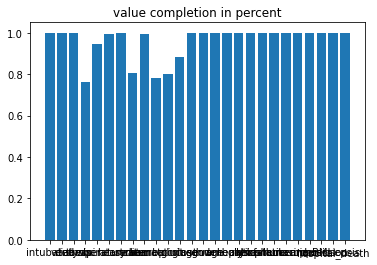

In [ ]:
relative_missing_values = my_df_all_patients.isnull().sum()/len(my_df_all_patients)
relative_recorded_values = 1 - relative_missing_values
plt.bar(relative_recorded_values.index, relative_recorded_values)
plt.title("value completion in percent")
plt.show()

## exporting parsly cleaned non scaled dataframes

export all patients table

In [ ]:
# Write the DataFrame to CSV file.
with open('/content/drive/MyDrive/CHAIPH_PROJECT_GR2/data/final_dataframes/all_patients/my_df_all_patients_cleaned.csv', 'w') as f:
  my_df_all_patients.to_csv(f)

export the sepsis patients table

In [ ]:
my_df_sepsis_patients.to_csv(r'/content/drive/MyDrive/CHAIPH_PROJECT_GR2/data/final_dataframes/sepsis_patients/my_df_sepsis_patients_cleaned.csv', header=True)

### Inputting values with K-nearest neighbours method:

#### scalling data:

In [ ]:
# scaling values to use KNN imputation:
scaler = MinMaxScaler()
my_df_all_patients = pd.DataFrame(scaler.fit_transform(my_df_all_patients), columns=my_df_all_patients.columns)
my_df_sepsis_patients = pd.DataFrame(scaler.fit_transform(my_df_sepsis_patients), columns=my_df_sepsis_patients.columns)

In [ ]:
# verifying scaling:
print("descriptive statistics: \n") 
my_df_all_patients.describe()

descriptive statistics: 



,intubated,vent,dialysis,wbc,temperature,respiratoryrate,heartrate,sodium,meanbp,hematocrit,creatinine,glucose,glasgow,gender,age,thrombolytics,aids,hepaticfailure,lymphoma,metastaticcancer,leukemia,immunosuppression,cirrhosis,BMI,hospital_death,sepsis
count,143700.000000,143700.000000,143700.000000,109308.000000,136061.000000,142702.000000,143285.000000,115665.000000,143086.000000,112254.000000,115155.000000,126823.000000,143700.000000,143668.000000,143700.000000,143700.000000,143700.000000,143700.000000,143700.000000,143700.000000,143700.000000,143700.000000,143700.000000,143700.000000,143700.000000,143700.000000
mean,0.148365,0.238838,0.037439,0.064257,0.736912,0.377330,0.401498,0.451020,0.292865,0.438372,0.058140,0.069332,0.834835,0.455509,0.691677,0.017300,0.001148,0.016193,0.004586,0.021781,0.007648,0.028358,0.018963,0.316924,0.082811,0.129422
std,0.355462,0.426375,0.189836,0.042157,0.041394,0.268771,0.154329,0.053196,0.260382,0.113310,0.070498,0.043754,0.284866,0.498018,0.190663,0.130387,0.033866,0.126219,0.067564,0.145970,0.087117,0.165993,0.136395,0.134131,0.275598,0.335668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.038958,0.726457,0.125000,0.335000,0.423077,0.087500,0.357377,0.024145,0.040747,0.833333,0.000000,0.579545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.225566,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.054246,0.739910,0.410714,0.420000,0.451923,0.162500,0.440984,0.035010,0.056876,1.000000,0.000000,0.715909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.292690,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.080078,0.748879,0.571429,0.500000,0.480769,0.518750,0.518033,0.059557,0.084465,1.000000,1.000000,0.840909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.381268,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### inputting:

In [ ]:
# inputting missing values with K-nearest neighbour method:
imputer = KNNImputer(n_neighbors=5)
my_df_all_patients = pd.DataFrame(imputer.fit_transform(my_df_all_patients), columns=my_df_all_patients.columns)
my_df_sepsis_patients = pd.DataFrame(imputer.fit_transform(my_df_sepsis_patients), columns=my_df_sepsis_patients.columns)

#### verifying inputation :

In [ ]:
relative_missing_values = my_df_all_patients.isnull().sum()/len(my_df_all_patients)
print("\n\nmissing values in percent:")
print(relative_missing_values)



missing values in percent:
intubated            0.0
vent                 0.0
dialysis             0.0
wbc                  0.0
temperature          0.0
respiratoryrate      0.0
heartrate            0.0
sodium               0.0
meanbp               0.0
hematocrit           0.0
creatinine           0.0
glucose              0.0
glasgow              0.0
gender               0.0
age                  0.0
thrombolytics        0.0
aids                 0.0
hepaticfailure       0.0
lymphoma             0.0
metastaticcancer     0.0
leukemia             0.0
immunosuppression    0.0
cirrhosis            0.0
BMI                  0.0
hospital_death       0.0
sepsis               0.0
dtype: float64


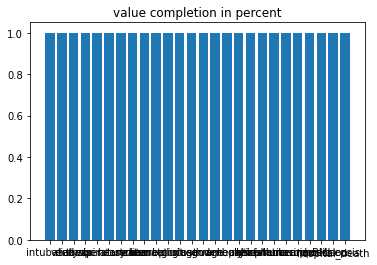

In [ ]:
relative_recorded_values = 1 - relative_missing_values
plt.bar(relative_recorded_values.index, relative_recorded_values)
plt.title("value completion in percent")
plt.show()

## exporting scaled dataframes

In [ ]:
# Write the DataFrame to CSV file.
with open('/content/drive/MyDrive/CHAIPH_PROJECT_GR2/data/final_dataframes/all_patients/my_df_all_patients_scaled.csv', 'w') as f:
  my_df_all_patients.to_csv(f)

In [ ]:
# Write the DataFrame to CSV file.
with open('/content/drive/MyDrive/CHAIPH_PROJECT_GR2/data/final_dataframes/sepsis_patients/my_df_all_sepsis_scaled.csv', 'w') as f:
  my_df_sepsis_patients.to_csv(f)